Juypter Notebook for generating a synthetic data set to test memory consupmtion of the framework

In [30]:
import numpy as np
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_track(
    touch_id,    
    n_frames=100,
    start_offset=10,
    chaos={'x': 0.05, 'y': 0.05, 'z': 0.1},
    canvas={'x': [0,640], 'y': [0,480], 'z': [-0.75, 0]},
    z_frequency = 4,
    shape='ellipse'
):
    '''
    Erzeugt einen simulierten 3D-Track im gegebenen Wertebereich.
    
    Parameter:
        n_frames: Anzahl an Frames (nach dem Offset)
        start_offset: Anzahl an Null-Frames am Anfang
        chaos: Dikt mit Varianzfaktoren für x, y, z
        canvas_size: Wertebereich
        shape: 'ellipse' oder 'zigzag'
    '''
    canvas_size = { 'x': canvas['x'][1] - canvas['x'][0], 'y': canvas['y'][1] - canvas['y'][0], 'z': canvas['z'][1] - canvas['z'][0]}

    x_center = canvas_size['x'] / 2
    y_center = canvas_size['y'] / 2
    x_radius = canvas_size['x'] * 0.45
    y_radius = canvas_size['y'] * 0.45
    
    frames = []

    for i in range(n_frames):
        t = i / n_frames * 2 * np.pi  # Parameter für Verlauf
        
        if shape == 'ellipse':
            x = x_center + x_radius * np.cos(t)
            y = y_center + y_radius * np.sin(t)
        elif shape == 'zigzag':
            x = i / n_frames * canvas_size['x']
            y = y_center + ((-1)**i) * y_radius * 0.8
        elif shape == 'spiral':
            r = i / n_frames
            x = x_center + r * x_radius * np.cos(t * 2)
            y = y_center + r * y_radius * np.sin(t * 2)
        elif shape == 'wave':
            x = i / n_frames * canvas_size['x']
            y = y_center + y_radius * 0.4 * np.sin(t * 2)
        elif shape == 'grid-snaked':
            cols = int(np.sqrt(n_frames))
            rows = n_frames // cols
            col = i % cols
            row = i // cols
            x_step = canvas_size['x'] / cols
            y_step = canvas_size['y'] / rows
            x = col * x_step
            y = row * y_step
            if row % 2 == 1:
                x = canvas_size['x'] - x

        elif shape == 'diagonal-loop':
            diag = min(canvas_size['x'], canvas_size['y'])
            r = i / n_frames
            x = x_center + r * diag * np.cos(t * 4)
            y = y_center + r * diag * np.sin(t * 4)  
        else:
            raise ValueError('Unsupported shape')
        
        x += canvas['x'][0]
        y += canvas['y'][0]
        
        z_min = canvas['z'][0]
        z_max = canvas['z'][1]

        z_raw = np.sin(t * z_frequency)  # [-1, 1]  # wellenförmiges Z
        z = ((z_raw + 1) * 0.5) * (z_max - z_min) + z_min
 

        # Rauschen (Chaos)
        x += np.random.normal(0, chaos['x'] * canvas_size['x'])
        y += np.random.normal(0, chaos['y'] * canvas_size['y'])
        z += np.random.normal(0, chaos['z'] * abs(z_max - z_min))

        # Clamping
        x = float(np.clip(x, canvas['x'][0], canvas['x'][1]))
        y = float(np.clip(y, canvas['y'][0], canvas['y'][1]))
        z = float(np.clip(z, z_min, z_max))

        frames.append({'x': x, 'y': y, 'z': z})

    # Start-Offset-Frames
    offset_frames = [{'x': 0.0, 'y': 0.0, 'z': 0.0}] * start_offset

    track = {
        'touchId': touch_id,
        'frames': offset_frames + frames
    }

    return track


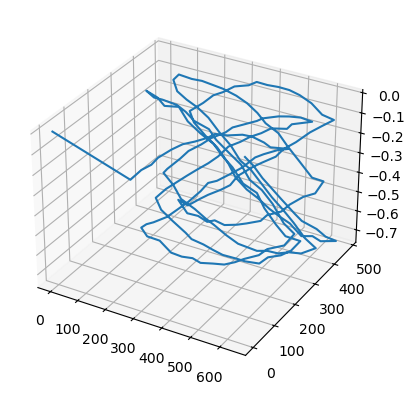

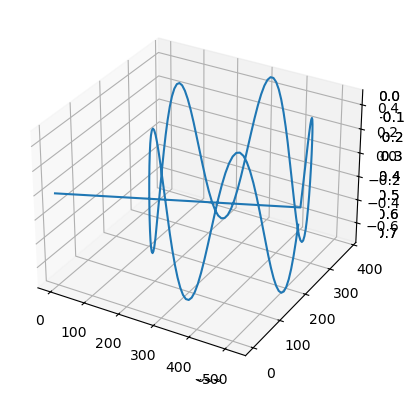

In [36]:
track1 = generate_track(
    1,
    n_frames=220,
    start_offset=40,
    chaos={'x': 0.01, 'y': 0.01, 'z': 0.01},
    canvas={'x': [100,640], 'y': [200,480], 'z': [-0.75, 0]},
    shape='grid-snaked',
    z_frequency=5
)

coords = np.array([[f['x'], f['y'], f['z']] for f in track1['frames']])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(coords[:,0], coords[:,1], coords[:,2])
plt.show()

track2 = generate_track(
    2,
    n_frames=240,
    start_offset=0,
    chaos={'x': 0.01, 'y': 0.01, 'z': 0.01},
    canvas={'x': [100,640], 'y': [200,480], 'z': [-0.75, 0]},
    shape='diagonal-loop',
    z_frequency=5
)

track3 = generate_track(
    3,
    n_frames=150,
    start_offset=100,
    chaos={'x': 0.0, 'y': 0.00, 'z': 0.00},
    canvas={'x': [100,540], 'y': [50,400], 'z': [-0.75, 0.5]},
    shape='ellipse',
    z_frequency=5
)

fig = plt.figure()

coords1 = np.array([[f['x'], f['y'], f['z']] for f in track1['frames']])
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot(coords1[:,0], coords1[:,1], coords1[:,2])

coords2 = np.array([[f['x'], f['y'], f['z']] for f in track2['frames']])
ax2 = fig.add_subplot(111, projection='3d')
ax2.plot(coords2[:,0], coords2[:,1], coords2[:,2])

coords3 = np.array([[f['x'], f['y'], f['z']] for f in track3['frames']])
ax3 = fig.add_subplot(111, projection='3d')
ax3.plot(coords3[:,0], coords3[:,1], coords3[:,2])

plt.show()

data = { 'id': 1, 'name': 'evaluation_data_set', 'numFrames': 400, 'speed': 0.2, 'tracks': [track1, track2, track3] }
# Export als JSON-Datei
with open('track_output.json', 'w') as f: 
  json.dump(data, f, indent=2)